# Feature selection

In [18]:
import numpy as np
import pandas as pd
import pickle 

In [19]:
with open('crafted/df_cleaned.pickle', 'rb') as handle:
    df = pickle.load(handle)

df.shape

(1056320, 25)

In [20]:
df_small = df.drop(columns=['date', 'account_id'])
df_small

,date_dayofweek,date_day,date_week,date_month,date_year,date_days_from_last_trans,type_credit,type_withdrawal,type_cash,op_credit_from_bank,...,op_withdrawal_in_cash,amount,balance,k_symbol_household,k_symbol_statement,k_symbol_loan,k_symbol_insurance,k_symbol_pension,k_symbol_credited_interest,k_symbol_sanction_interest
trans_id,,,,,,,,,,,,,,,,,,,,,
1,4,24,12,3,2,0,1,0,0,0,...,0,1000,1000,0,0,0,0,0,0,0
5,3,13,15,4,2,20,1,0,0,1,...,0,3679,4679,0,0,0,0,0,0,0
199,6,23,16,4,2,10,1,0,0,0,...,0,12600,17279,0,0,0,0,0,0,0
3530438,6,30,17,4,2,7,1,0,0,0,...,0,19,17298,0,0,1,0,0,0,0
6,5,13,19,5,2,13,1,0,0,1,...,0,3679,20977,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3431284,2,2,49,12,5,2,0,1,0,0,...,1,25600,41114,0,0,0,0,0,0,0
3431109,3,10,50,12,5,8,1,0,0,1,...,0,46248,87362,0,0,0,0,0,0,0
3431152,4,25,52,12,5,15,0,1,0,0,...,1,6300,81062,0,0,0,0,0,0,0


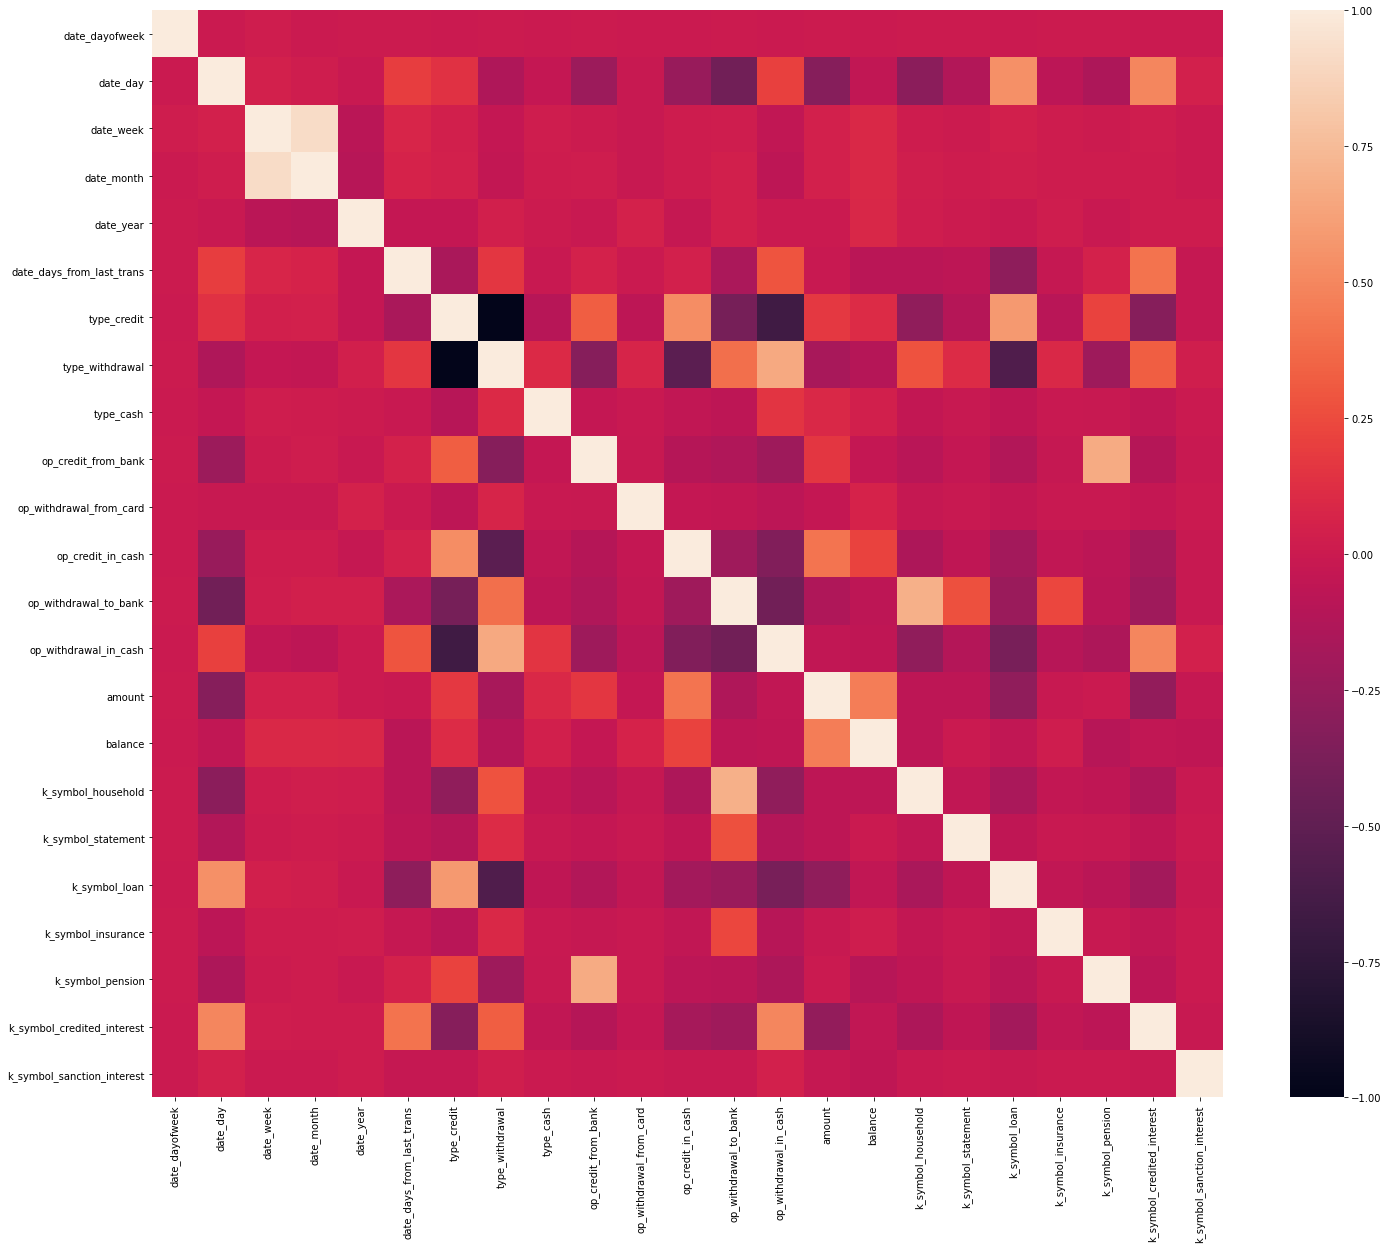

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(24,20))
cor = df_small.corr(method='pearson')
sns.heatmap(cor)
plt.show()

In [22]:
threshold = 0.9

keep_columns = list(range(len(df_small.columns)))
drop_columns = []
for i in keep_columns[:-1]:
    for j in keep_columns[i+1:]:
        if np.abs(cor.iloc[i,j]) >= threshold:
            if j in keep_columns:
                drop_columns.append(j)

keep_columns = [col for col in keep_columns if col not in drop_columns]
                
selected_columns_pearson = df_small.columns.values[keep_columns]
dropped_columns_pearson = df_small.columns.values[drop_columns]

df_pearson_small = df_small[selected_columns_pearson]
print('\nThe dropped columns are the following:')
print(dropped_columns_pearson)
print('\nThe following columns are present in the new df:')
print(selected_columns_pearson)
print(f'\nThe old df had {df_small.shape[1]} features. The new df has {df_pearson_small.shape[1]} features.')


The dropped columns are the following:
['date_month' 'type_withdrawal']

The following columns are present in the new df:
['date_dayofweek' 'date_day' 'date_week' 'date_year'
 'date_days_from_last_trans' 'type_credit' 'type_cash'
 'op_credit_from_bank' 'op_withdrawal_from_card' 'op_credit_in_cash'
 'op_withdrawal_to_bank' 'op_withdrawal_in_cash' 'amount' 'balance'
 'k_symbol_household' 'k_symbol_statement' 'k_symbol_loan'
 'k_symbol_insurance' 'k_symbol_pension' 'k_symbol_credited_interest'
 'k_symbol_sanction_interest']

The old df had 23 features. The new df has 21 features.


In [23]:
df = df.drop(columns=dropped_columns_pearson)
print(df.shape)
df.columns

(1056320, 23)


Index(['account_id', 'date_dayofweek', 'date_day', 'date_week', 'date_year',
       'date_days_from_last_trans', 'date', 'type_credit', 'type_cash',
       'op_credit_from_bank', 'op_withdrawal_from_card', 'op_credit_in_cash',
       'op_withdrawal_to_bank', 'op_withdrawal_in_cash', 'amount', 'balance',
       'k_symbol_household', 'k_symbol_statement', 'k_symbol_loan',
       'k_symbol_insurance', 'k_symbol_pension', 'k_symbol_credited_interest',
       'k_symbol_sanction_interest'],
      dtype='object')

In [24]:
#from skfeature.function.similarity_based.lap_score import lap_score

#lap_score(df.values)

In [27]:
def build_transaction_sequences(df, slice_size):        
    #slice_size = 2 # [example: 2]

    # extended column names as '<n_of_transaction>_<col_name>' [example: '2_amount' => 2nd transaction of the sequence, field amount]
    cols = np.concatenate([df.columns.map(lambda x: str(i)+'_'+x).values for i in range(slice_size)])

    slice_sized_values = [] 
    for account_id in df['account_id'].unique():
        df_account = df[df['account_id']==account_id]
        
        # extracted sequences of length slice_size from dataframe [example: (239, 25) => (238, 2, 25)]
        slices = np.array([df_account.iloc[i:i+slice_size,:].values for i in range(len(df_account)-slice_size+1)])

        # linearized transactions from the same sequence into single lines [example: (238, 2, 25) => (238, 50)]
        slices = slices.reshape(len(df_account)-slice_size+1, len(cols))

        # all sequences of transactions from the single account are stored into the new future dataframe
        slice_sized_values.append(slices)
    
    sequences = pd.DataFrame(
        data = np.concatenate(slice_sized_values, axis=0),
        columns = [col for col in cols if not(col.endswith('date') or col.endswith('account_id'))]
    )
    
    sequences = sequences.drop(columns=[
        col 
        for col in sequences.columns 
        if (col.endswith('date') or col.endswith('account_id'))
    ])
    
    with open('crafted/sequences_{}trans.pickle'.format(slice_size), 'wb') as handle:
        pickle.dump(sequences, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    return sequences


def get_transaction_sequences(df, slice_size):
    try:
        with open('crafted/sequences_{}trans.pickle'.format(slice_size), 'rb') as handle:
            sequences = pickle.load(handle)
        return sequences
    except:
        return build_transaction_sequences(df, slice_size)
    

In [ ]:
build_transaction_sequences(df, 2)

In [9]:
#i in [1,2,3,7] (currently)
#df = get_transaction_sequences(df, i)

In [10]:
def print_umap_graph(umap_df):
    umap_data = pd.DataFrame(
        data = umap_df,
        columns=['umap-2d-one', 'umap-2d-two']
    )

    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="umap-2d-one", y="umap-2d-two",
        palette=sns.color_palette("hls", 2),
        data=umap_data,
        legend="full",
        alpha=0.3
    )
    plt.show()

In [11]:
df = df.drop(columns=['account_id', 'date'])

In [12]:
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

In [13]:
scaled_df = StandardScaler().fit_transform(df)
%time umap_1trans_df = umap.UMAP().fit_transform(scaled_df[:100000,:])
print_umap_graph(umap_1trans_df)

KeyboardInterrupt: 

NameError: name 'umap_1trans_df' is not defined

### Looking at sequences

CPU times: user 20min 48s, sys: 5min 4s, total: 25min 52s
Wall time: 8min 7s


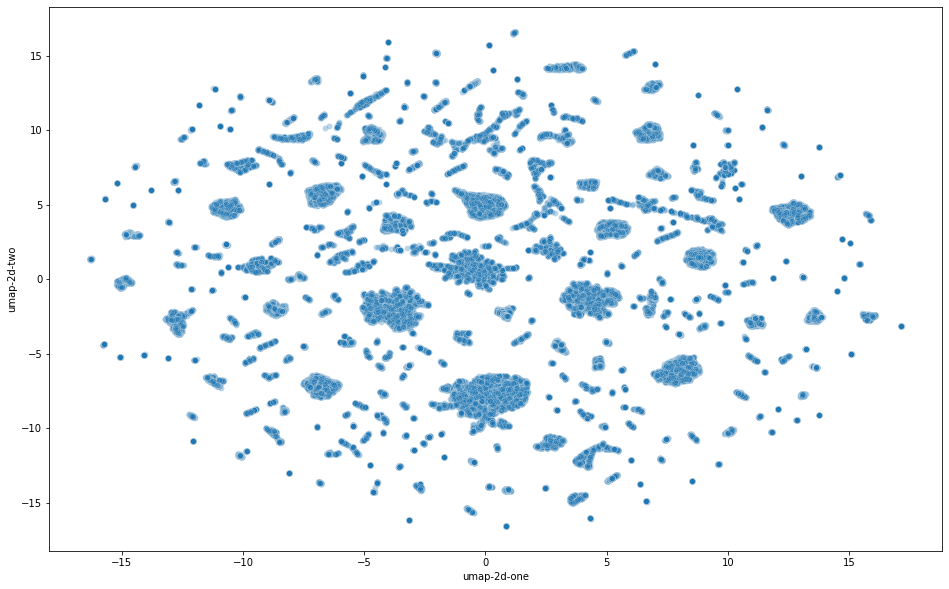

In [211]:
df_2trans = get_transaction_sequences(df, 2)
scaled_df_2trans = StandardScaler().fit_transform(df_2trans)
%time umap_2trans_df = umap.UMAP().fit_transform(scaled_df_2trans[:100000,:])
print_umap_graph(umap_2trans_df)

CPU times: user 12min 33s, sys: 2min 40s, total: 15min 14s
Wall time: 5min


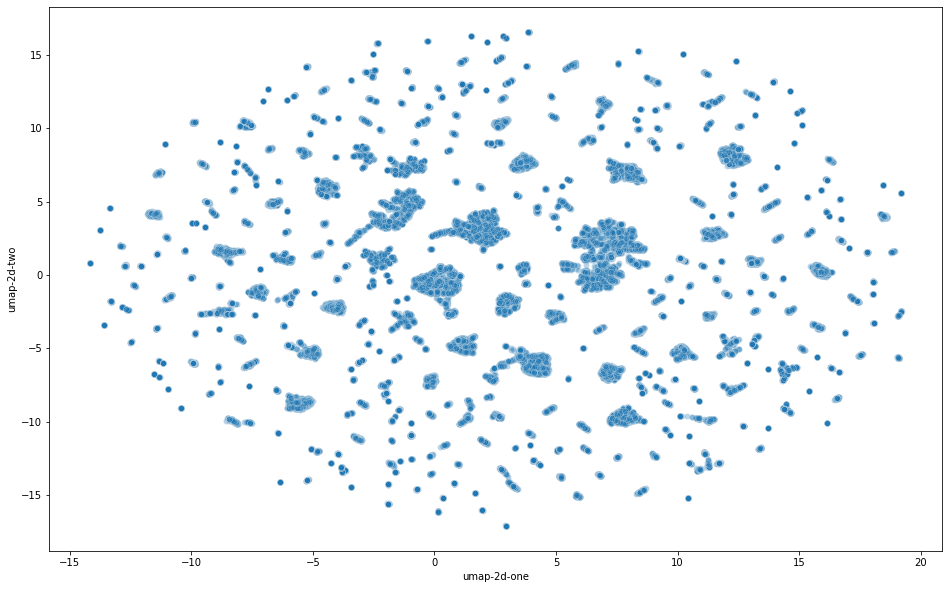

In [212]:
df_3trans = get_transaction_sequences(df, 3)
scaled_df_3trans = StandardScaler().fit_transform(df_3trans)
%time umap_3trans_df = umap.UMAP().fit_transform(scaled_df_3trans[:100000,:])
print_umap_graph(umap_3trans_df)

CPU times: user 4min 44s, sys: 28.8 s, total: 5min 13s
Wall time: 1min 31s


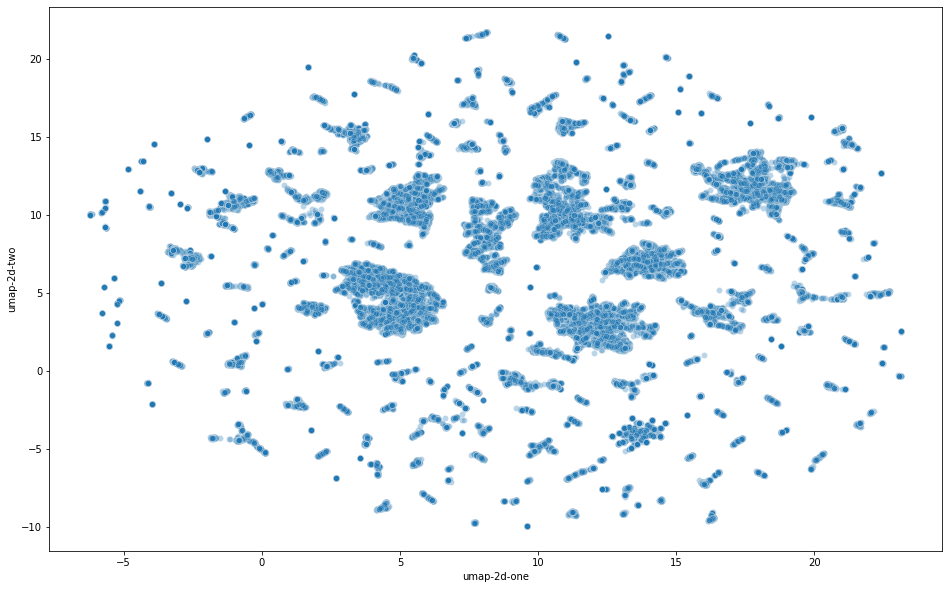

In [213]:
df_7trans = get_transaction_sequences(df, 7)
scaled_df_7trans = StandardScaler().fit_transform(df_7trans)
%time umap_7trans_df = umap.UMAP().fit_transform(scaled_df_7trans[:100000,:])
print_umap_graph(umap_7trans_df)

We have yet to deal with dimensionality that affects transaction sequences. One idea can be using a compressing algorithm (for example a shallow autoencoder) to compress the increasingly high amount of features (increasing with the amount of consecutive transactions taken into account) into a fixed-size length of features.  